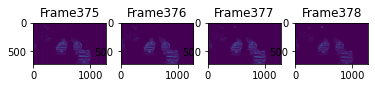

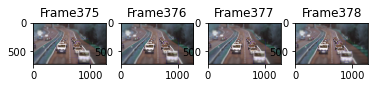

In [5]:
import os
import re
import cv2
import numpy as np
from os.path import isfile,join
import matplotlib.pyplot as plt
from tkinter import *
from tkinter import filedialog
import tkinter
grayframe_list=[]
originalframes=[]
diffframe_list=[]
def getFrames():
    global grayframe_list
    window=Tk()
    window.title('Video Viewer')
    capt=cv2.VideoCapture(filedialog.askopenfilename())
    window.mainloop()
    while(capt.isOpened()):
        ret,frame=capt.read()
        if ret:
            originalframes.append(frame)
            grayframe_list.append(cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY))
            if cv2.waitKey(30)&0xFF ==ord('q'):
                break
        else:
            break
    width = round(capt.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = round(capt.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps =(int)(1000/capt.get(cv2.CAP_PROP_FPS))
    capt.release()
    cv2.destroyAllWindows()
    return fps
def detectMotion():
    global grayframe_list
    global originalframes
    fps=getFrames()
    count=1
    height,width = grayframe_list[0].shape[0],grayframe_list[0].shape[1]
    sum=np.zeros((height,width))
    for i in grayframe_list:
        i=cv2.GaussianBlur(i,(3,3),0)
        sum+=i
        count+=1
    #Extract BackGround
    background=sum/count
    background=background.astype(np.uint8)
    kernel=np.ones((7,7),np.uint8)
    kernel2=np.ones((3,3),np.uint8)
    count=1
    for i in grayframe_list:
        #Subtract Frame from BG
        currentFrame=cv2.absdiff(i,background)
        if count != 1 and count != len(grayframe_list):
            nextFrame=cv2.absdiff(grayframe_list[count],background)
        else: nextFrame=cv2.absdiff(grayframe_list[count-1],background)
        result=cv2.absdiff(currentFrame,nextFrame)
        diffframe_list.append(result)
        result=cv2.multiply(result,2)+10
        _,im_bin=cv2.threshold(result,40,255,cv2.THRESH_BINARY)
        im_bin=cv2.dilate(im_bin,kernel,1)
        im_bin=cv2.erode(im_bin,kernel2,1)
        cnt, labels, stats, centroids=cv2.connectedComponentsWithStats(im_bin)
        for j in range(1,cnt):
            (x,y,w,h,area)=stats[j]
            if area < 1000:
                continue
            cv2.rectangle(originalframes[count-1],(x,y,w,h),(0,0,255))
        count+=1
        
    plotImage()
    for i in originalframes:
        cv2.imshow('',i)
        cv2.waitKey(fps)
    cv2.destroyAllWindows()
    
    return background
def plotImage():
    a=(int)(len(originalframes)/8)
    f, axarr = plt.subplots(1,4)
    for j in range(4):
        plt.title("Frame: "+str(j+a))
        axarr[j].imshow(diffframe_list[j+a])
        axarr[j].set_title('Frame'+str(j+a))
    plt.show()
    f, axarr = plt.subplots(1,4)
    for j in range(4):
        plt.title("Frame: "+str(j+a))
        axarr[j].imshow(originalframes[j+a])
        axarr[j].set_title('Frame'+str(j+a))    
    plt.show()

def detectSkin():
    fps=getFrames()
    global originalframes
    count=1
    for im in originalframes:
        YCrCb=cv2.cvtColor(im,cv2.COLOR_BGR2YCrCb)
        lower=np.array([0,138,77],dtype="uint8")
        upper=np.array([255,173,127],dtype="uint8")
        skinYCrCb=cv2.inRange(YCrCb,lower,upper)
        YCrCb=cv2.blur(skinYCrCb,(3,3))
        _,YCrCb=cv2.threshold(YCrCb,0,255,cv2.THRESH_OTSU)
        diffframe_list.append(YCrCb)
        cnt, labels, stats, centroids=cv2.connectedComponentsWithStats(YCrCb)
        for j in range(1,cnt):
            (x,y,w,h,area)=stats[j]
            if area < 300:
                continue
            cv2.rectangle(originalframes[count-1],(x,y,w,h),(0,0,255))
        count+=1
    plotImage()
    for i in originalframes:
        cv2.imshow('',i)
        cv2.waitKey(fps)
    cv2.destroyAllWindows()
    
win=Tk()
win.geometry('200x150')  
win.title('Video Recognition')
button1 =  Button(win,width=50,text="Object Detection", command=detectMotion).pack()
button2 =  Button(win,width=50, text="Skin Detection", command=detectSkin).pack()
win.mainloop()